In [1]:
#statistical
import pandas as pd
import numpy as np

#dataset
from sklearn.datasets import *

#mchine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

#graphing and display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

#feature engineer
import feature_engineer as fe

#other
from pprint import pprint

In [2]:
def display_metrics(y_test, y_pred):
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average = 'weighted')))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average = 'weighted')))
    print('F1 score: {:.2f}'.format(f1_score(y_test, y_pred, average = 'weighted')))

def train_and_predict(model, X_train, X_test, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def append_metric_results(df, metrics, y_test, y_pred, dataset_name, enriched_flag, columns):
    for metric_name, metric in metrics.items():
        to_append = pd.DataFrame([[dataset_name,
                                   enriched_flag,
                                   metric_name,
                                   metric['metric'](y_test, y_pred, **metric['kwargs'])]], columns = columns)
        df = df.append(to_append, ignore_index = True)
    
    return df

def get_results_before_after_enrichment(dataset, dataset_name, metrics, model, scorer,
                                        splitter, hyperparameters, results = None):
    
    
    dataset_x = pd.DataFrame(dataset.data, columns = dataset.feature_names)
    dataset_y = dataset.target
    
    X_train, X_test, y_train, y_test = splitter(dataset_x.copy(), dataset_y, **hyperparameters['splitter_kwargs'])
    
    y_pred_not_enriched = train_and_predict(model, X_train, X_test, y_train)
    
    results = append_metric_results(results, metrics, y_test, y_pred_not_enriched,
                                    dataset_name, False, results.columns)
    
    eng = fe.FeatureEngineer(model, scorer, splitter, n_best = hyperparameters['n_best'],
                             scorer_kwargs = hyperparameters['scorer_kwargs'],
                             splitter_kwargs = hyperparameters['splitter_kwargs'])
    eng.fit(X_train, y_train)
    
    eng.transform(X_train)
    eng.transform(X_test)
    
    y_pred_enriched = train_and_predict(model, X_train, X_test, y_train)
    
    enrichment_results = {}
    
    enrichment_results['engine'] = eng
    enrichment_results['dataset'] = dataset_name
    
    metrics_results = append_metric_results(results, metrics, y_test,
                                            y_pred_enriched, dataset_name,
                                            True, results.columns)
    
    enrichment_results['test_metrics'] = metrics_results
    
    return enrichment_results

In [3]:
iris = load_iris()
boston_housing = load_boston()
diabetes = load_diabetes()
linnerud = load_linnerud()
wine = load_wine()
breast_cancer = load_breast_cancer()

In [4]:
datasets = {'iris' : iris,
            'wine' : wine,
            'breast_cancer' : breast_cancer}

In [5]:
metrics = {'accuracy' : {'metric' : accuracy_score, 'kwargs' : {'normalize' : True}},
           'precision' : {'metric' : precision_score, 'kwargs' : {'average' : 'weighted'}},
           'recall' : {'metric' : recall_score, 'kwargs' : {'average' : 'weighted'}},
           'f1_score' : {'metric' : f1_score, 'kwargs' : {'average' : 'weighted'}}}

In [6]:
random_seed = 42
test_size = 0.3
hyperparameters = {'random_seed' : random_seed,
                   'test_size' : test_size,
                   'n_best' : 5,
                   'splitter_kwargs' : {'test_size' : test_size, 'random_state' : random_seed},
                   'scorer_kwargs' : {'average' : 'weighted'}}

In [7]:
results = pd.DataFrame(columns = ['dataset', 'enriched', 'metric', 'value'])

engines = {}

for dataset_name, dataset in datasets.items():
    print('processing ', dataset_name)
    model_results = get_results_before_after_enrichment(dataset, dataset_name,
                                                        metrics, GaussianNB(),
                                                        f1_score, train_test_split,
                                                        hyperparameters, results)
    engines[model_results['dataset']] = model_results
    results = model_results['test_metrics']

processing  iris


C:\Users\rossr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


processing  wine
processing  breast_cancer


C:\Users\rossr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:432: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
C:\Users\rossr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:434: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)


In [8]:
results.sort_values(by = ['dataset', 'metric', 'enriched'])

,dataset,enriched,metric,value
16,breast_cancer,False,accuracy,0.941520
20,breast_cancer,True,accuracy,0.953216
19,breast_cancer,False,f1_score,0.941317
23,breast_cancer,True,f1_score,0.953216
17,breast_cancer,False,precision,0.941391
21,breast_cancer,True,precision,0.953216
18,breast_cancer,False,recall,0.941520
22,breast_cancer,True,recall,0.953216
0,iris,False,accuracy,0.977778
4,iris,True,accuracy,1.000000


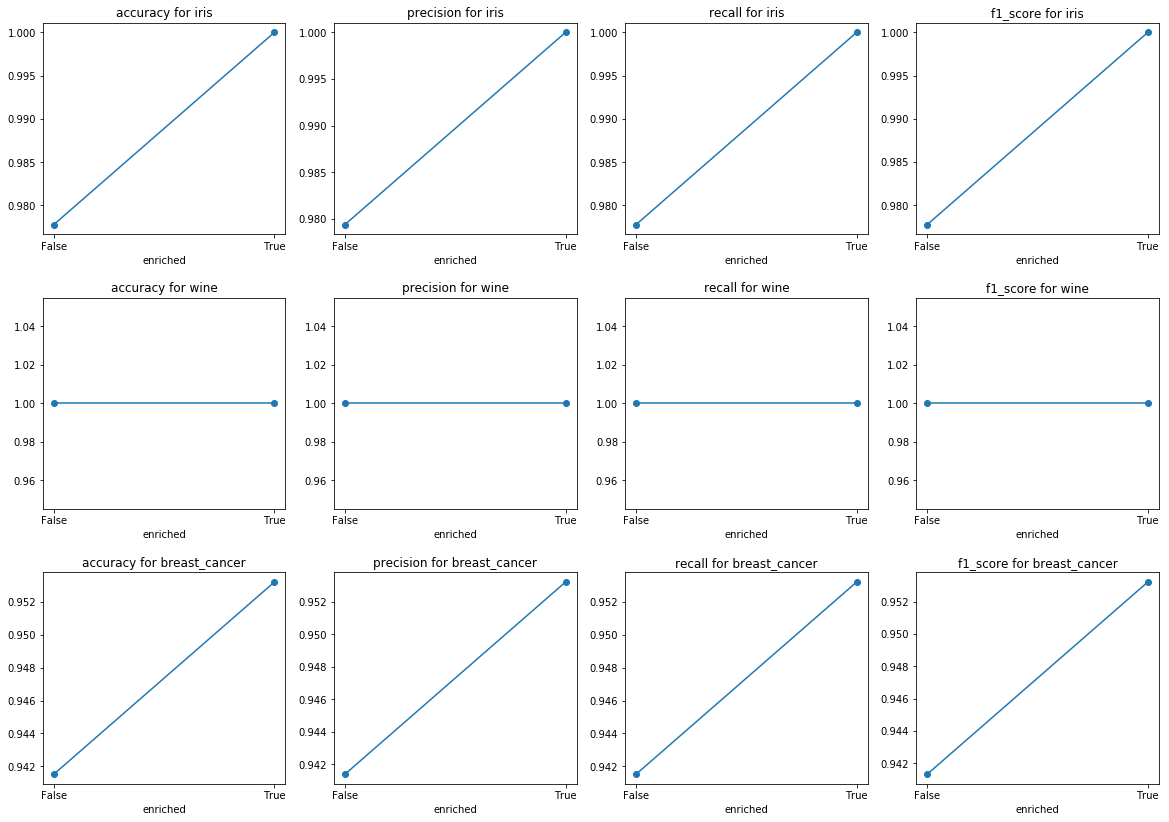

In [9]:
fig = plt.figure(figsize = (20, 14))
len_x = len(results.dataset.unique())
len_y = len(results.metric.unique())
i = 0
for dataset in results.dataset.unique():
    for metric in results.metric.unique():
        i += 1
        ax = plt.subplot(len_x, len_y, i)
        to_plot = results[(results.dataset == dataset) & (results.metric == metric)]
        x_ticks = np.arange(len(to_plot.enriched))
        ax.plot(x_ticks, to_plot.value, marker = 'o')
        ax.set_title('%s for %s' % (metric, dataset))
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(to_plot.enriched.tolist())
        ax.set_xlabel('enriched')
plt.subplots_adjust(hspace = 0.3)

In [10]:
best_feature_columns = ['dataset', 'feature', 'score']
best_features = pd.DataFrame(columns = best_feature_columns)
for dataset, dataset_res in engines.items():
    for score, feature in dataset_res['engine'].best_columns.items():
        to_append = pd.DataFrame([[dataset, feature['column_name'], score]],
                                 columns = best_feature_columns)
        best_features = best_features.append(to_append, ignore_index = True)

In [11]:
best_features.sort_values(by = ['dataset', 'score'], ascending = False)

,dataset,feature,score
5,wine,min_(proline)_truediv_flavanoids,0.892676
6,wine,proline_mul_alcohol,0.890704
9,wine,proline_sub_magnesium,0.885853
7,wine,proline_mul_ash,0.871067
8,wine,flavanoids_mul_magnesium,0.868345
0,iris,petal width (cm)_truediv_sepal width (cm),0.968750
3,iris,petal width (cm)_mul_sepal width (cm),0.937500
1,iris,petal width (cm)_add_petal length (cm),0.937216
2,iris,petal width (cm)_mul_petal length (cm),0.906250
4,iris,petal length (cm)_truediv_sepal width (cm),0.905821
